# This notebook checks the results after a simulation

## init stuff

In [377]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [378]:
import sys
sys.path.append('..')

In [379]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

import shutil

In [380]:
import sumolib

In [381]:
from utils.data_utils.network_utils import flatten, get_downstream_edges, get_upstream_edges, get_edge_to_level_dict
from utils.result_utils.plot_utils import plotNet
from utils.result_utils.file_utils import xml2csv_path
from utils.result_utils.dotdict import DotDict
from utils.general_utils.conversion_utils import convert_seconds_to_24h
from utils.data_utils.data_loader_utils import transform_df_to_tensor, get_index_to_edge_dicts

In [411]:
scenario = 'motorway'
experiment_name = 'incident2'
path = f'../{scenario}/Results/{experiment_name}'
error_path = f'{scenario}/Results/error_sims'


In [401]:
result_folders = os.listdir(path)
print(f'{len(result_folders)} simulations')
#result_folders

4000 simulations


In [402]:

experiment_folders = [folder for folder in result_folders if folder.startswith(experiment_name)]

In [403]:
print(f'{len(experiment_folders)} experiments')

4000 experiments


In [414]:
for folder in experiment_folders:
    result_xmls = [xml for xml in glob.glob(f'{path}/{folder}/*.xml') if 'log' not in xml]
    if len(glob.glob(f'{path}/{folder}/*.csv')) < len(result_xmls):
        print(f'Found fewer csv files than xml files in {folder}. Converting results')
        shutil.move(f'{path}/{folder}', f'{error_path}/{folder}')
        
        #xml2csv_path(f'{path}/{folder}')
        #print(f'finished converting {folder}')
    #else: print(f"All files in {folder} seems converted.")

# Load incident and net

In [398]:
#net_path = '../experiment/Simulations/Base/traci_exp.net.xml'
net_path = '../motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

In [399]:
# 16 shows not smooth enough 18 is the one I did stuff on
experiment = experiment_folders[18]
experiment_path = f'{path}/{experiment}'
#experiment_path = f'{path}/incident1_257'

print(experiment_path)
#os.listdir(experiment_path)

with open(f'{experiment_path}/incident_settings.json') as f:
    incident_settings = json.load(f)
print(incident_settings)

incident_edge = incident_settings['edge']
i_edge_obj = net.getEdge(incident_edge)

hours, minutes, seconds = convert_seconds_to_24h(incident_settings['start_time'])
print(f'Incident at {hours}:{minutes}:{seconds}')

../motorway/Results/incident3/incident3_82
{'slow_zone': 70, 'lc_zone': 20, 'lc_prob_zone': 170, 'slow_zone_speed': 13.8, 'run_num': 82, 'is_incident': True, 'is_random': True, 'random_seed': 2128896184, 'edge': '48290550', 'lanes': [0, 1], 'pos': 52.65908492261612, 'start_time': 5579, 'start_step': 11158, 'duration_time': 1130, 'duration_steps': 2260}
Incident at 1:32:59


In [13]:
n_up = 3
n_down = 3

downstream_edges_ids = get_downstream_edges(i_edge_obj, 3)
all_downstream_edges_ids = flatten(list(downstream_edges_ids.values()))

upstream_edges_ids = get_upstream_edges(i_edge_obj, 3)
all_upstream_edges_ids = flatten(list(upstream_edges_ids.values()))

edge_to_level_dict = get_edge_to_level_dict(upstream_edges_ids, downstream_edges_ids, incident_edge)

relevant_edges = all_upstream_edges_ids + all_downstream_edges_ids + [incident_edge]
upstream_edges = all_upstream_edges_ids + [incident_edge]
downstream_edges = all_downstream_edges_ids + [incident_edge]

edge_to_level_dict

{'gneE4': 'upstream_0_0',
 'gneE3': 'upstream_1_0',
 'gneE2': 'upstream_2_0',
 '4414080#1-AddedOnRampEdge.675': 'upstream_3_0',
 'gneE7': 'downstream_0_0',
 'gneE10': 'downstream_1_0',
 'gneE11': 'downstream_2_0',
 'gneE12': 'downstream_3_0',
 'gneE6': 'incident_edge'}

# Map

In [14]:
#net_path = '../experiment/Simulations/Base/traci_exp.net.xml'
net_path = '../motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)
plot_options = {'defaultColor': 'black',
                'defaultWidth': 2}
plot_options = DotDict(plot_options)
edge_colors = {incident_edge: 'red'}

for i in range(n_up):
    for id in upstream_edges_ids[i]:
        edge_colors[id] = 'orange'
        
for i in range(n_down):
    for id in downstream_edges_ids[i]:
        edge_colors[id] = 'blue'
        
fig, ax = plt.subplots(1, figsize=(10,10))
plotNet(net, edge_colors, {}, plot_options, i_edge_obj, ax)


<AxesSubplot:>

## check counterfactuals

In [15]:
results_incident = pd.read_csv(f'{experiment_path}/edgedata.csv', sep=';')
results_incident = results_incident[['edge_id', 'interval_begin', 'edge_density', 'edge_occupancy', 'edge_speed', 'edge_waitingTime', 'edge_timeLoss']]
results_incident_table = results_incident.pivot(index='edge_id', columns='interval_begin', values=['edge_speed','edge_density'])

counterfactual_incident = pd.read_csv(f'{experiment_path}/edgedata_counterfactual.csv', sep=';')
counterfactual_incident = counterfactual_incident[['edge_id', 'interval_begin', 'edge_density', 'edge_occupancy', 'edge_speed', 'edge_waitingTime', 'edge_timeLoss']]
counterfactual_incident_table = counterfactual_incident.pivot(index='edge_id', columns='interval_begin', values=['edge_speed','edge_density'])



In [16]:
results_incident

edge_id  interval_begin  edge_density  \
0                       106130759         73046.0         10.02   
1      106130759-AddedOffRampEdge         73046.0           NaN   
2                  106130759.1186         73046.0          2.50   
3                  106130759.1630         73046.0           NaN   
4                  106130759.1868         73046.0           NaN   
...                           ...             ...           ...   
67468                       gneE2         86786.0           NaN   
67469                       gneE3         86786.0           NaN   
67470                       gneE4         86786.0           NaN   
67471                       gneE6         86786.0           NaN   
67472                       gneE7         86786.0           NaN   

       edge_occupancy  edge_speed  edge_waitingTime  edge_timeLoss  
0                1.28       27.03               0.0           4.23  
1                 NaN         NaN               NaN            NaN  
2                0.32       29.19               0.0           0.46  
3                 NaN         NaN               NaN            NaN  
4                 NaN         NaN               NaN            NaN  
...               ...         ...               ...            ...  
67468             NaN         NaN               NaN            NaN  
67469             NaN         NaN               NaN            NaN  
67470             NaN         NaN               NaN            NaN  
67471             NaN         NaN               NaN            NaN  
67472             NaN         NaN               NaN            NaN  

[67473 rows x 7 columns]

In [17]:
results_incident_table.iloc[0].loc['edge_speed'].index[1] - results_incident_table.iloc[0].loc['edge_speed'].index[0]

30.0

In [18]:
upstream_edges

['gneE4', 'gneE3', 'gneE2', '4414080#1-AddedOnRampEdge.675', 'gneE6']

In [19]:
chosen_edges = upstream_edges
#chosen_edges = ['106130759']

fig, ax = plt.subplots(2,2)

results_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,0], legend=False)
ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
results_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,0], legend=False)

counterfactual_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,1], legend=False)
ax[0,1].set_title(f'Counterfactual')
counterfactual_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,1], legend=False)

ax[0,0].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[1,0].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[0,1].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[1,1].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[0,0].set_ylim(-1, 30)
ax[1,0].set_ylim(-1, 600)
ax[0,1].set_ylim(-1, 30)
ax[1,1].set_ylim(-1, 600)


ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)
plt.savefig('fig1.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [20]:
chosen_edges = upstream_edges


fig, ax = plt.subplots(1,1)

results_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax, legend=False)
ax.set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')

ax.set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax.set_ylim(-1, 30)


ax.axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax.axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)
plt.savefig('fig1.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Attempt at backlog

<AxesSubplot:xlabel='interval_begin'>

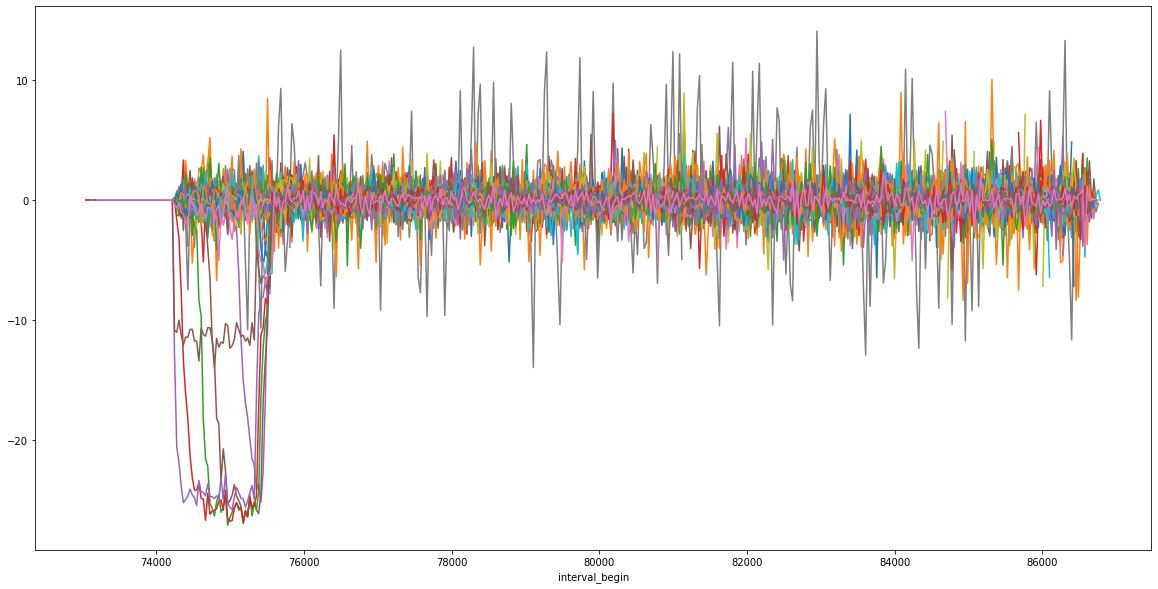

In [25]:
fig, ax = plt.subplots(1)
(results_incident_table.edge_speed - counterfactual_incident_table.edge_speed).T.plot(figsize=(20,10), legend=False, ax=ax)
#ax.set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 5000)



In [26]:
edge_colors_2 = {}
for handle in handles:
        edge_colors_2[handle.get_label()] = handle.get_color()

In [27]:
# 3 area = {'xmin':500 , 'xmax':3000 ,'ymin':4000 ,'ymax':8000 }
#area = {'xmin':2000 , 'xmax':2500 ,'ymin':5700 ,'ymax':6800 }
fig, ax = plt.subplots(1, figsize=(10,10))
#plotNet(net, edge_colors_2, {}, plot_options, i_edge_obj, ax, area=area)
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)
plotNet(net, edge_colors_2, {}, plot_options, i_edge_obj, ax, margin=1000)

<AxesSubplot:>

In [28]:
chosen_edges = incident_edge


fig, ax = plt.subplots(2,2)

results_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,0], legend=False)
ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
results_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,0], legend=False)

counterfactual_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,1], legend=False)
ax[0,1].set_title(f'Counterfactual')
counterfactual_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,1], legend=False)

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 600)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 600)


ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

## Compare edge with detector data

In [144]:
results_detector = pd.read_csv(f'{experiment_path}/detectordata.csv', sep=';')
#results_detector = results_detector.replace(-1,np.nan)
results_detector_table = results_detector.pivot(index='interval_id', columns='interval_begin', values=['interval_flow',
                                                                                                       'interval_harmonicMeanSpeed',
                                                                                                       'interval_nVehContrib',
                                                                                                       'interval_speed'])
#results_detector_table = results_detector_table.groupby(results_detector_table.index.str.split('_').str[1]).mean().T

In [145]:





counterfactual_detector = pd.read_csv(f'{experiment_path}/detectordata_counterfactual.csv', sep=';')
counterfactual_detector = counterfactual_detector.replace(-1,np.nan)



#results_detector_table = results_detector_table.groupby(results_detector_table.index.str.split('_').str[1]).mean().T
#counterfactual_detector_table = counterfactual_detector_table.groupby(counterfactual_detector_table.index.str.split('_').str[1]).mean().T

### Create dataframe structure instead

In [313]:
inci_df = pd.read_csv(f'{experiment_path}/detectordata.csv', sep=';')
inci_data = transform_df_to_tensor(inci_df, interpolation_lim=50)[:,:,10:,:]

counter_df = pd.read_csv(f'{experiment_path}/detectordata_counterfactual.csv', sep=';')
counter_data = transform_df_to_tensor(counter_df, interpolation_lim=50)[:,:,10:,:]

ind_to_edge, edge_to_ind = get_index_to_edge_dicts(inci_df)

interval_begin           0
interval_occupancy       0
interval_speed        3057
dtype: int64
interval_begin           0
interval_occupancy       0
interval_speed        3207
dtype: int64


In [314]:
# TODO SAVE THIS LANE MASK
lane_mask = ~(inci_data[...,2].mean(-1) == -1)

In [315]:
[edge_to_ind[edge] for edge in upstream_edges]

[144, 143, 142, 85, 145]

In [316]:
edge_to_ind[incident_edge]

145

In [317]:
5000 / 30

166.66666666666666

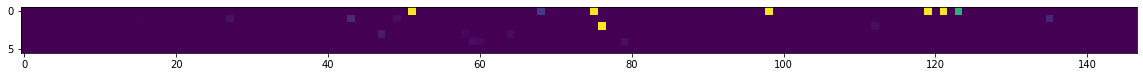

In [323]:
fix, ax = plt.subplots(1, figsize=(20, 20))
ax.imshow((inci_data[...,2] == 0).sum(2).T)


In [372]:
sorted_edges = (inci_data[...,2] == 0).sum((1,2)).argsort()
biggest = sorted_edges[-11:]
(inci_data[...,2] == 0).sum((1,2))[biggest]

array([ 31,  46,  49,  70, 269, 409, 409, 409, 409, 409, 415])

In [373]:
for edge in biggest:
    print(f'{ind_to_edge[edge]} {(inci_data[...,2] == 0).sum(2)[edge]}')
    

293596618#1-AddedOffRampEdge [ 0  0  0 31  0  0]
75266085 [ 0 46  0  0  0  0]
28531510 [ 0 49  0  0  0  0]
41517592 [70  0  0  0  0  0]
615002705#0 [269   0   0   0   0   0]
61047111-AddedOnRampEdge [409   0   0   0   0   0]
48290551#1 [409   0   0   0   0   0]
328393125-AddedOnRampEdge [409   0   0   0   0   0]
431199180 [409   0   0   0   0   0]
54121214 [409   0   0   0   0   0]
4402237 [  0   0 415   0   0   0]


In [374]:
plot_options = {'defaultColor': 'black',
                'defaultWidth': 2}
plot_options = DotDict(plot_options)
edge_colors = {incident_edge: 'red'}

for idx in biggest:
        edge_colors[ind_to_edge[idx]] = 'orange'

edge_colors[incident_edge] = 'red'        

fig, ax = plt.subplots(1, figsize=(10,10))
area = {'xmin':0 , 'xmax':5000 ,'ymin':0 ,'ymax':10000 }
plotNet(net, edge_colors, {}, plot_options, i_edge_obj, ax, area=area)



<AxesSubplot:>

In [343]:
net.getEdge('4402237').getLaneNumber()

3

(0.0, 30.0)

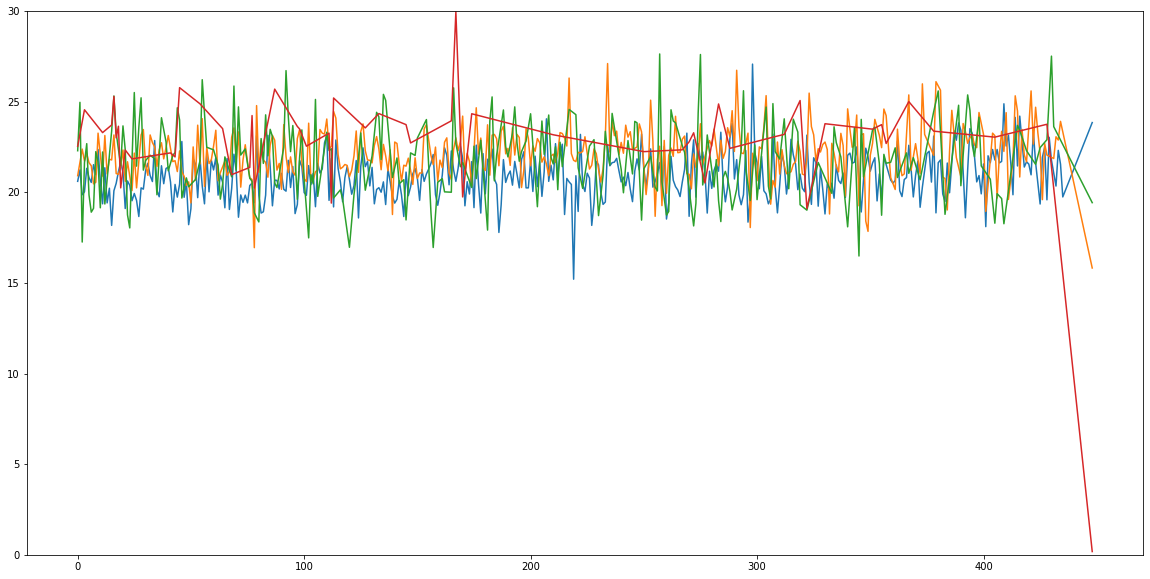

In [376]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.plot(inci_data[31, :, :, 2].T)
#ax.set_xlim(0 , )
ax.set_ylim(0, 30)

(0.0, 30.0)

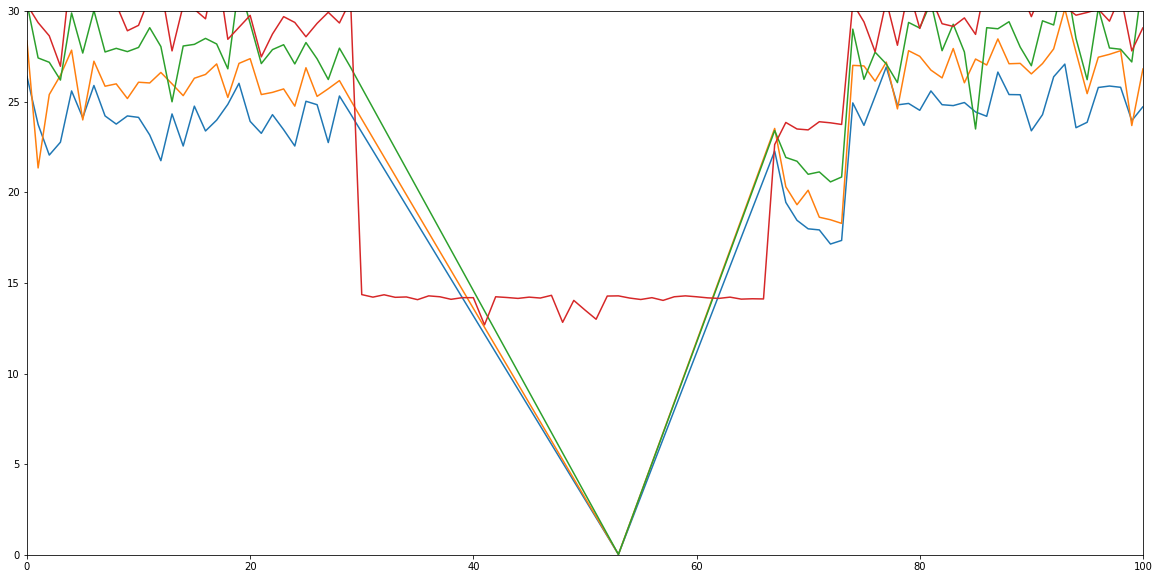

In [311]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.plot(inci_data[145, :, :, 2].T)
ax.set_xlim(0 , 100)
ax.set_ylim(0, 30)

(0.0, 30.0)

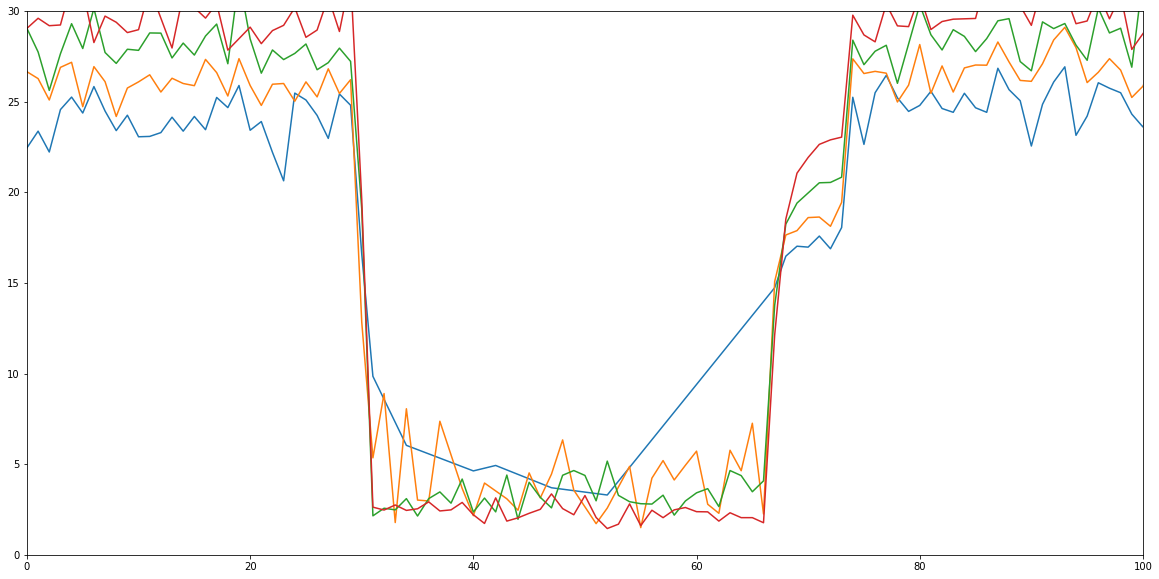

In [312]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.plot(inci_data[144, :, :, 2].T)
ax.set_xlim(0 , 100)
ax.set_ylim(0, 30)

In [295]:
residual_data = inci_data - counter_data[:, :, :-1,:]

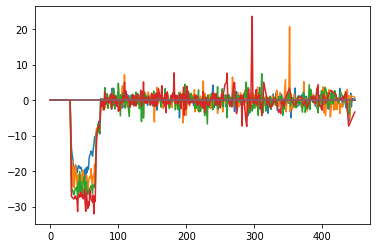

In [296]:
plt.plot(residual_data[144,:, : ,2].T)

In [163]:
residual_data.shape[1]

6

In [164]:
lane_stds = counter_data[...,2].std(2)

n_up = 5
n_down = 5

downstream_edges_ids = get_downstream_edges(i_edge_obj, n_down)
all_downstream_edges_ids = flatten(list(downstream_edges_ids.values()))

upstream_edges_ids = get_upstream_edges(i_edge_obj, n_up)
all_upstream_edges_ids = flatten(list(upstream_edges_ids.values()))

edge_to_level_dict = get_edge_to_level_dict(upstream_edges_ids, downstream_edges_ids, incident_edge)

relevant_edges = all_upstream_edges_ids + all_downstream_edges_ids + [incident_edge]
upstream_edges = all_upstream_edges_ids + [incident_edge]
downstream_edges = all_downstream_edges_ids + [incident_edge]

edge_to_level_dict

{'gneE4': 'upstream_0_0',
 'gneE3': 'upstream_1_0',
 'gneE2': 'upstream_2_0',
 '4414080#1-AddedOnRampEdge.675': 'upstream_3_0',
 '4414080#1-AddedOnRampEdge.343': 'upstream_4_0',
 '4414080#1-AddedOnRampEdge': 'upstream_5_0',
 'gneE7': 'downstream_0_0',
 'gneE10': 'downstream_1_0',
 'gneE11': 'downstream_2_0',
 'gneE12': 'downstream_3_0',
 'gneE6': 'incident_edge'}

In [165]:
upstream_look = [incident_edge] + all_upstream_edges_ids
upstream_look = [edge_to_ind[edge] for edge in upstream_look]
downstream_look = [incident_edge] + all_downstream_edges_ids
downstream_look = [edge_to_ind[edge] for edge in downstream_look]

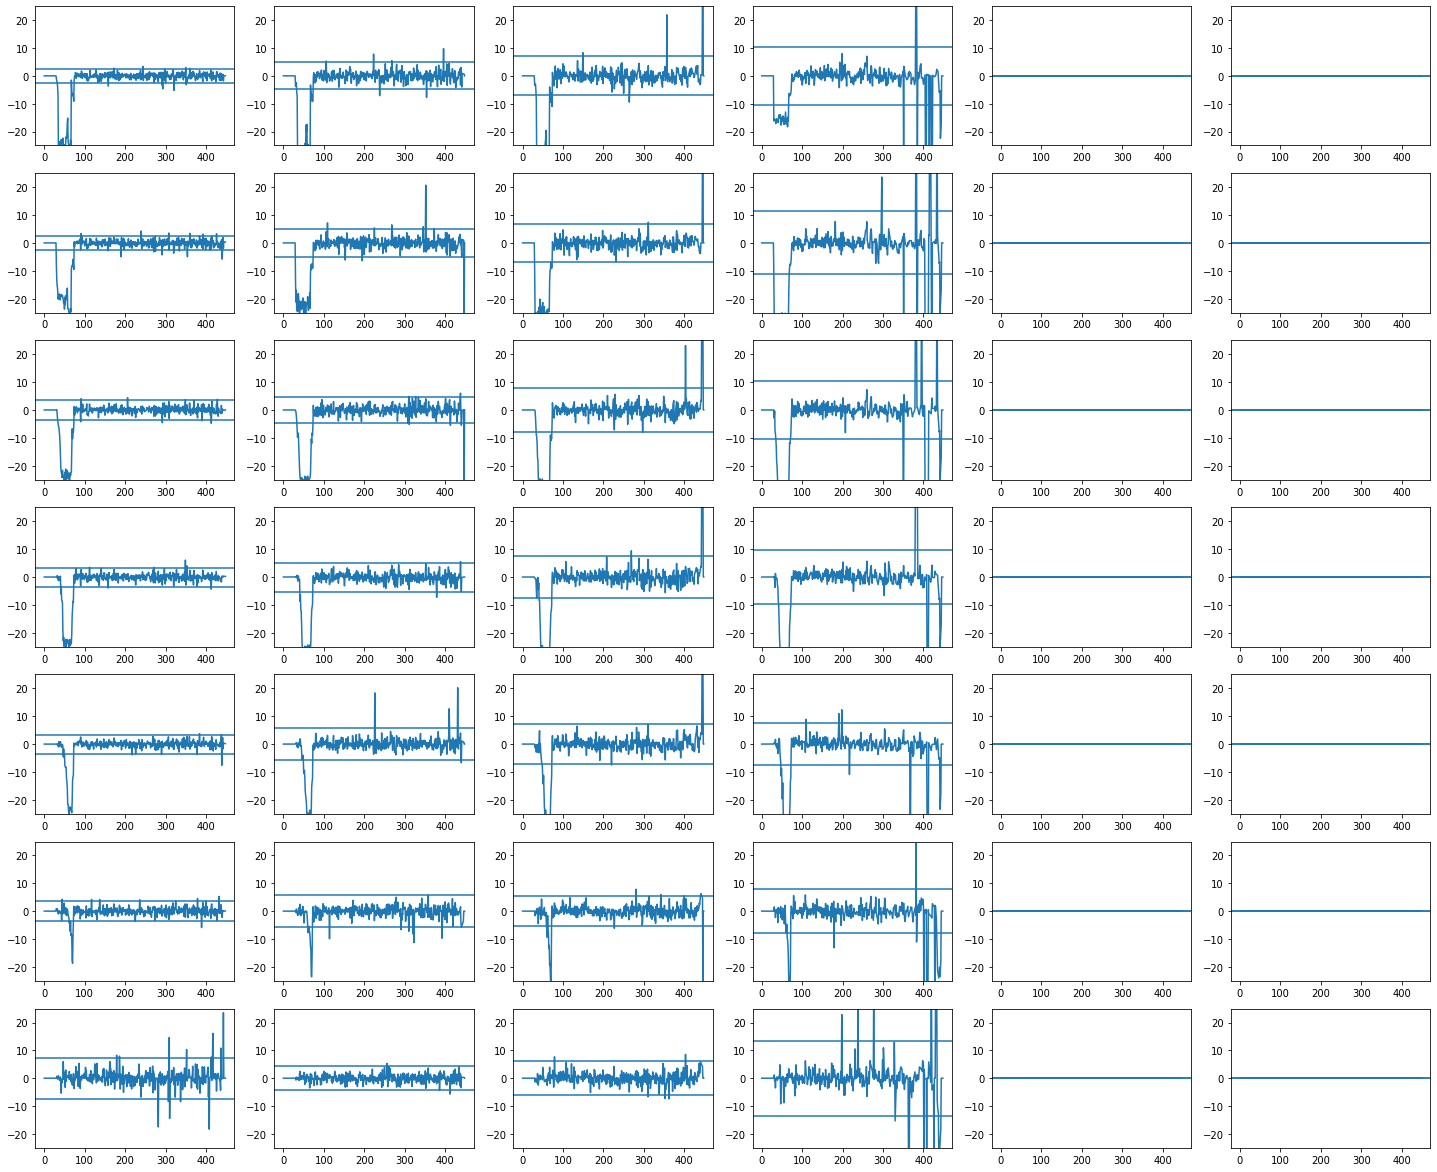

In [166]:
fig, ax = plt.subplots(len(upstream_look), 6, figsize = (25,3*len(upstream_look)))
for i, edge in enumerate(upstream_look):
    for lane in range(residual_data.shape[1]):
        ax[i,lane].plot(residual_data[edge,lane,:,2].T)
        ax[i,lane].axhline(1.95 * lane_stds[edge,lane])
        ax[i,lane].axhline(1.95 * -lane_stds[edge,lane])
        ax[i,lane].set_ylim(-25,25)
#ax.plot(residual_data.reshape(-1, 471,3)[7, : ,2])
#ax.set_xlim(0,200)

In [167]:
fig, ax = plt.subplots(len(downstream_look), 6, figsize = (25,5*len(downstream_look)))
for i, edge in enumerate(downstream_look):
    for lane in range(residual_data.shape[1]):
        ax[i,lane].plot(residual_data[edge,lane,:,2].T)
        ax[i,lane].axhline(1.95 * lane_stds[edge,lane])
        ax[i,lane].axhline(1.95 * -lane_stds[edge,lane])
        ax[i,lane].set_ylim(-25,25)
#ax.plot(residual_data.reshape(-1, 471,3)[7, : ,2])
#ax.set_xlim(0,200)

In [44]:
plt.plot(counter_data[104, :, :, 2].T - inci_data[104, :, :, 2].T)

In [446]:
def idxs_of_longest_seq(a1):
    idx_pairs = np.where(np.diff(np.hstack(([False],a1==1,[False]))))[0].reshape(-1,2)

    if len(idx_pairs) != 0:
        # Get the island lengths, whose argmax would give us the ID of longest island.
        # Start index of that island would be the desired output
        idxs_longest_seq = idx_pairs[np.diff(idx_pairs,axis=1).argmax()]
        length_seq = np.diff(idxs_longest_seq)[0]
    else:
        idxs_longest_seq = np.array([0, len(a1)])
        length_seq = 0
    return idxs_longest_seq, length_seq


# Backlog based on counterfactual

In [447]:
lane_stds = counter_data[...,2].std(2)
residual_speed = residual_data[...,2]
affect_bool_arr = (residual_speed.transpose(2,0,1) < -1.95*lane_stds)
arr = affect_bool_arr.transpose(1,2,0).reshape(-1, 449)
longest_affect_idxs, longest_affect_lengths = zip(*[idxs_of_longest_seq(row) for row in arr])
longest_affect_lengths = np.stack(longest_affect_lengths).reshape(147,6)
longest_affect_idxs = np.stack(longest_affect_idxs).reshape(147,6,2)
affected_edges = (longest_affect_lengths > 20).any(axis=1)
edge_idxs = np.where(affected_edges)[0]
affected_edges.sum()


10

In [466]:
[ind_to_edge[edge] for edge in edge_idxs]

['208416643',
 '4414080#1-AddedOnRampEdge.675',
 '48290550.1480',
 'gneE10',
 'gneE11',
 'gneE2',
 'gneE3',
 'gneE4',
 'gneE6',
 'gneE7']

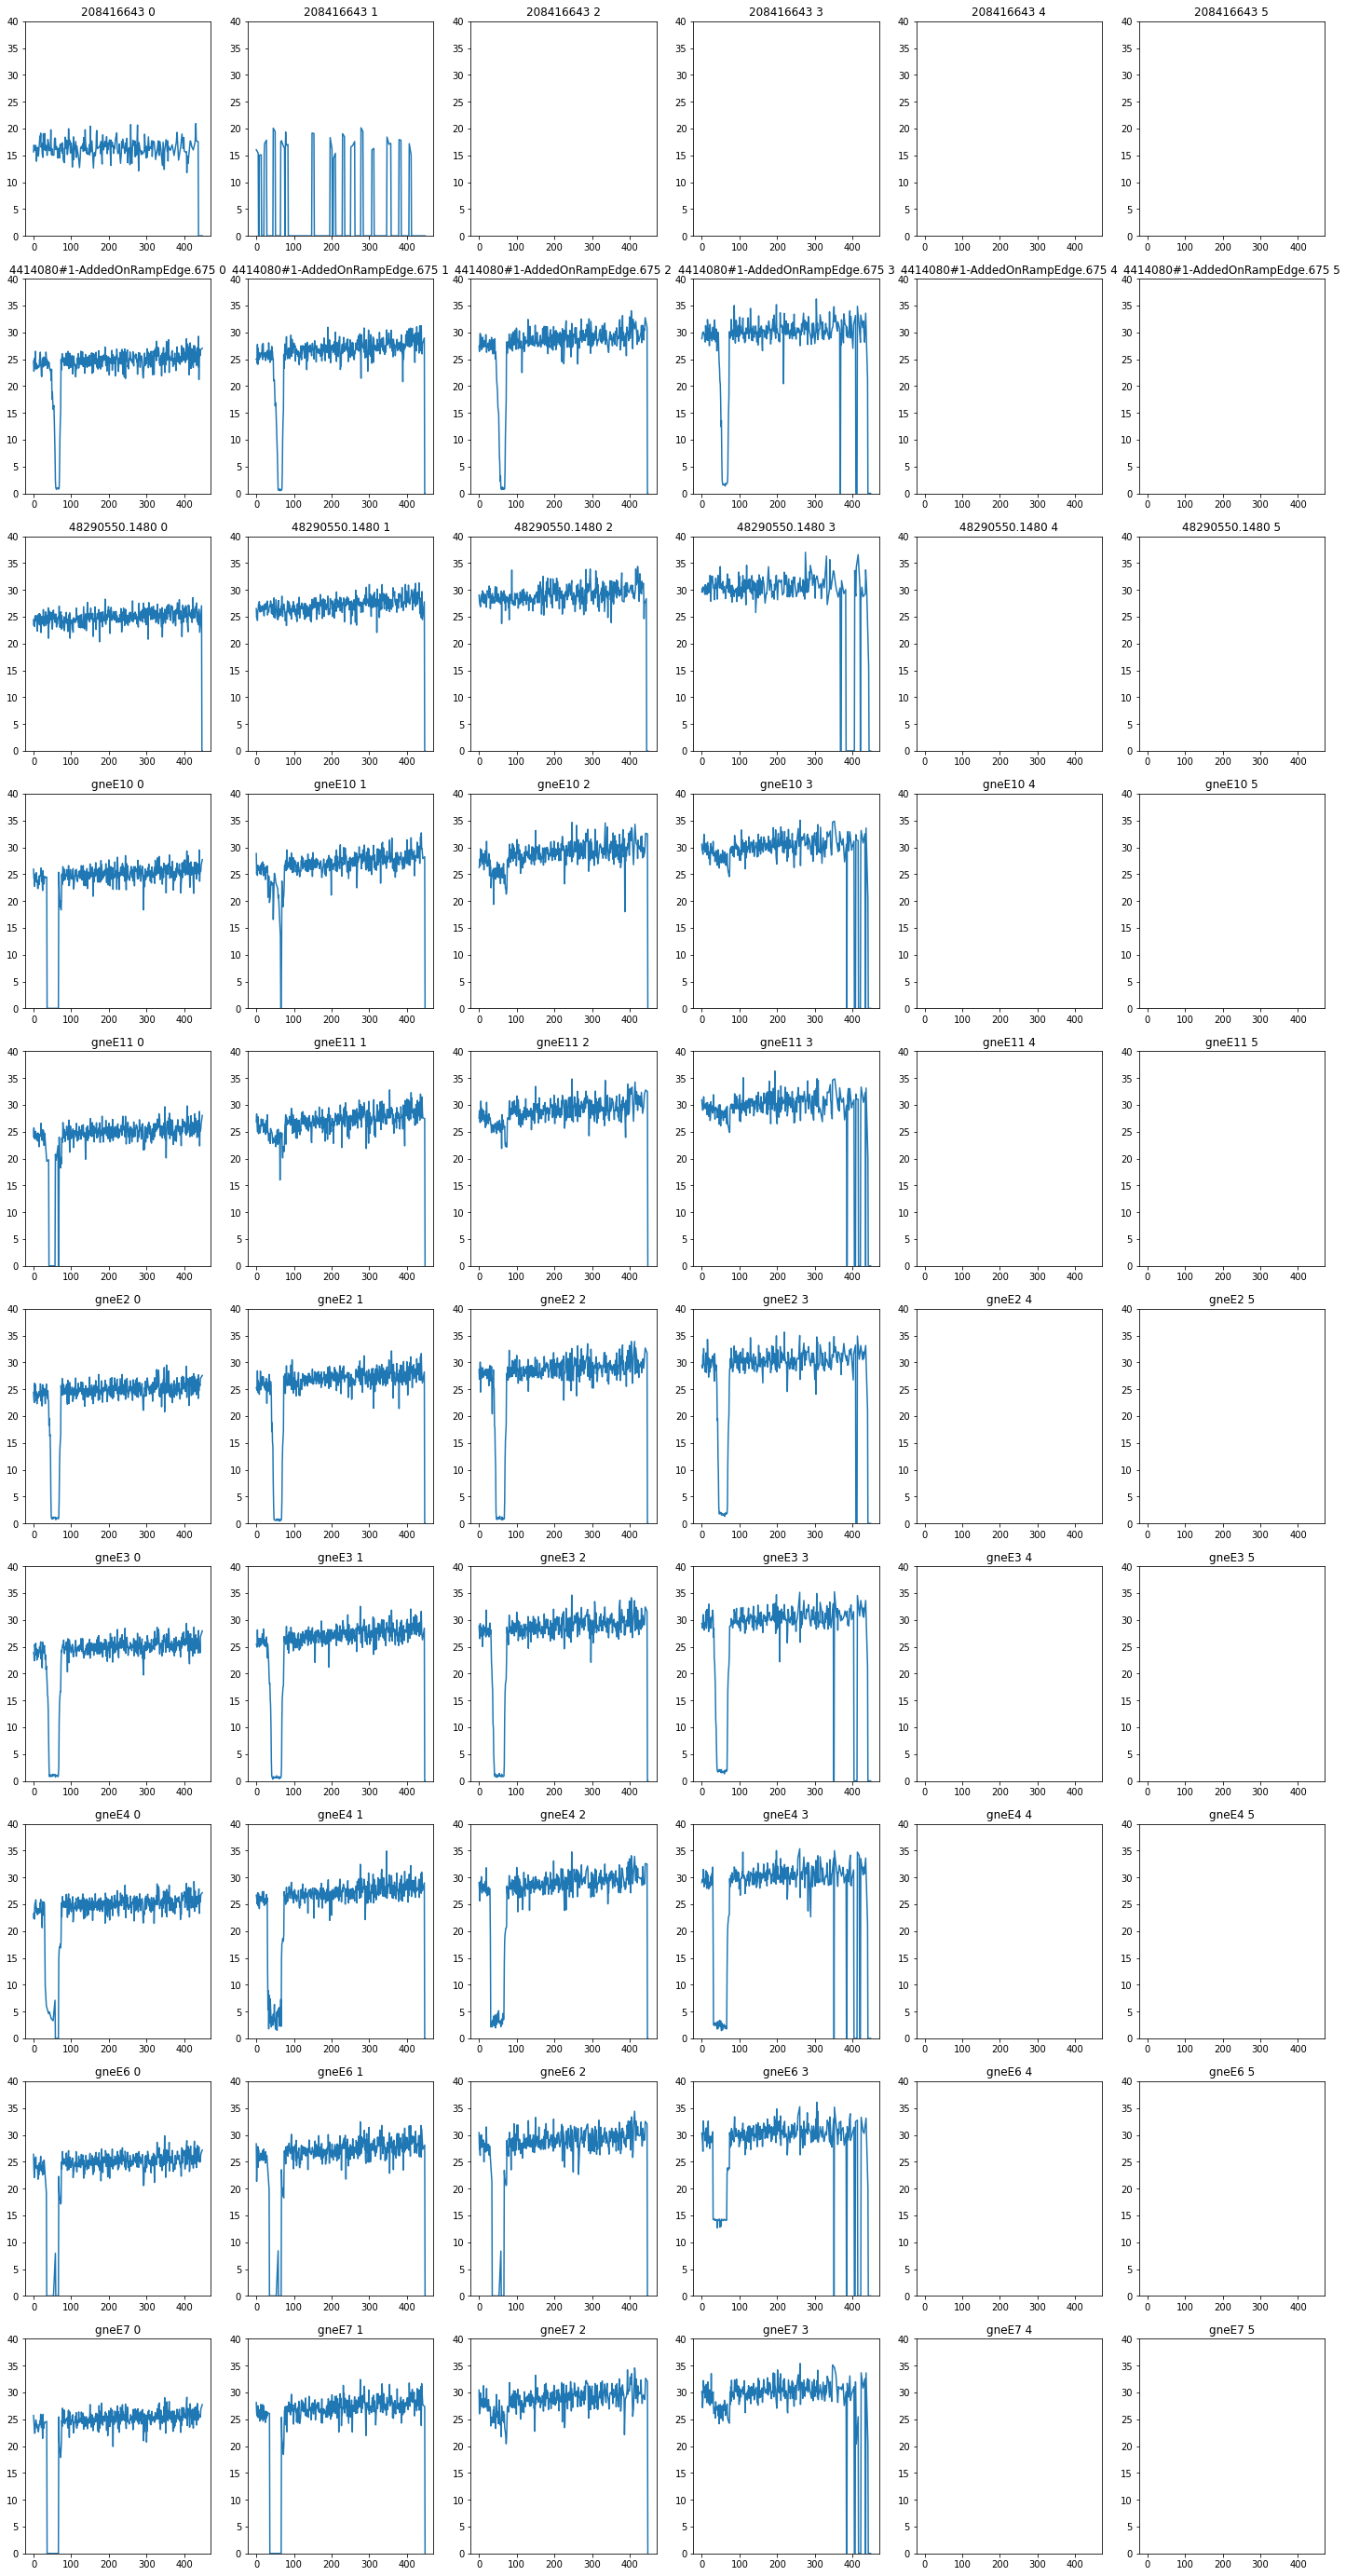

In [463]:
fig, ax = plt.subplots(len(edge_idxs), 6, figsize = (25,5*len(edge_idxs)))
for i, edge in enumerate(edge_idxs):
    for lane in range(residual_data.shape[1]):
        ax[i,lane].plot(inci_data[edge,lane,:,2].T)
        #x[i,lane].axhline(1.95 * lane_stds[edge,lane])
        #x[i,lane].axhline(1.95 * -lane_stds[edge,lane])
        ax[i,lane].set_ylim(0, 40)
        ax[i,lane].set_title(f'{ind_to_edge[edge]} {lane}')
#ax.plot(residual_data.reshape(-1, 471,3)[7, : ,2])
#ax.set_xlim(0,200)

<AxesSubplot:>

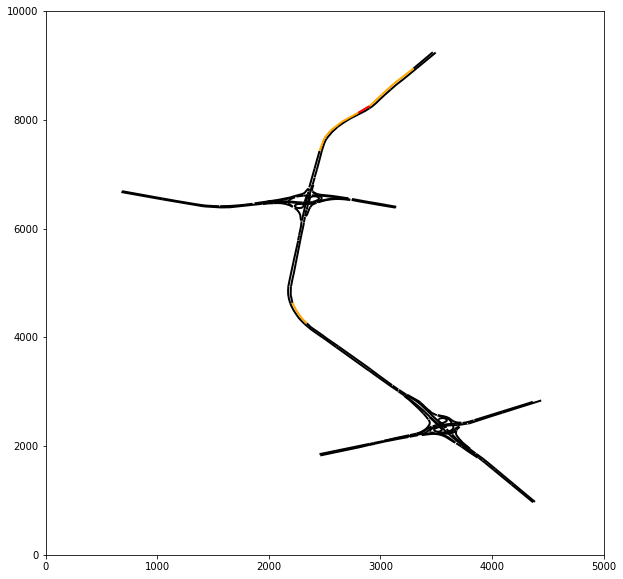

In [460]:
plot_options = {'defaultColor': 'black',
                'defaultWidth': 2}
plot_options = DotDict(plot_options)
edge_colors = {incident_edge: 'red'}

for idx in edge_idxs:
        edge_colors[ind_to_edge[idx]] = 'orange'

edge_colors[incident_edge] = 'red'        

fig, ax = plt.subplots(1, figsize=(10,10))
area = {'xmin':0 , 'xmax':5000 ,'ymin':0 ,'ymax':10000 }
plotNet(net, edge_colors, {}, plot_options, i_edge_obj, ax, area=area)



In [473]:
fig, ax = plt.subplots(1, figsize=(10,10))
area = {'xmin':2500 , 'xmax':4000 ,'ymin':2000 ,'ymax':3000 }
plotNet(net, edge_colors, {}, plot_options, i_edge_obj, ax, area=area)

<AxesSubplot:>

# Backlog based on LoS

In [480]:

inci_speed_bool = inci_speed.transpose(2,0,1) < 5
arr = inci_speed_bool.transpose(1,2,0).reshape(-1, 449)
longest_affect_idxs, longest_affect_lengths = zip(*[idxs_of_longest_seq(row) for row in arr])
longest_affect_lengths = np.stack(longest_affect_lengths).reshape(147,6)
longest_affect_idxs = np.stack(longest_affect_idxs).reshape(147,6,2)
affected_edges = (longest_affect_lengths > 20).any(axis=1)
edge_idxs = np.where(affected_edges)[0]
affected_edges.sum()


146

In [487]:
inci_speed = inci_data[...,2]
inci_speed_bool = inci_speed.transpose(2,0,1) < 5

In [492]:
inci_speed_bool.sum(0)

array([[ 10,   9,   8,  12, 449, 449],
       [  7,   6,   6,   6,  29, 449],
       [  7,   7,   8,   9, 449, 449],
       [  8,   7,   8,   8, 449, 449],
       [  8,   7,   7,   8, 449, 449],
       [  7,   6,   6,   9, 449, 449],
       [  7,   6,   6,  33, 449, 449],
       [  8,   8,   8,   9, 449, 449],
       [  1,   0,   2, 449, 449, 449],
       [  7,  50,   0,  11, 449, 449],
       [  9, 449, 449, 449, 449, 449],
       [  7,  43, 449, 449, 449, 449],
       [  9,  14, 449, 449, 449, 449],
       [  4,   5, 449, 449, 449, 449],
       [  7,   8,  90,   8,  31, 449],
       [  7,   8, 102, 449, 449, 449],
       [  7, 166, 449, 449, 449, 449],
       [  7,   8,  15, 449, 449, 449],
       [  0,  25, 449, 449, 449, 449],
       [  6,   0,  41, 449, 449, 449],
       [  7,   6, 449, 449, 449, 449],
       [  6, 449, 449, 449, 449, 449],
       [  7,  13, 449, 449, 449, 449],
       [  7, 449, 449, 449, 449, 449],
       [  2, 449, 449, 449, 449, 449],
       [  2, 449, 449, 44

In [481]:
fig, ax = plt.subplots(len(edge_idxs), 6, figsize = (25,5*len(edge_idxs)))
for i, edge in enumerate(edge_idxs):
    for lane in range(residual_data.shape[1]):
        ax[i,lane].plot(inci_data[edge,lane,:,2].T)
        #x[i,lane].axhline(1.95 * lane_stds[edge,lane])
        #x[i,lane].axhline(1.95 * -lane_stds[edge,lane])
        ax[i,lane].set_ylim(0, 40)
        ax[i,lane].set_title(f'{ind_to_edge[edge]} {lane}')
#ax.plot(residual_data.reshape(-1, 471,3)[7, : ,2])
#ax.set_xlim(0,200)

In [434]:
chosen_edges = [incident_edge]
chosen_lanes = counterfactual_detector_table.columns.str.split('_').str[1].isin(chosen_edges)



fig, ax = plt.subplots(2,2)

results_detector_table.loc['interval_speed', chosen_lanes].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table.loc['interval_occupancy', chosen_lanes].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table.loc['interval_speed', chosen_lanes].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table.loc['interval_occupancy', chosen_lanes].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

#ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
#ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
#ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
#ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[0,0].set_ylim(-1, 30)
ax[1,0].set_ylim(-1, 100)
ax[0,1].set_ylim(-1, 30)
ax[1,1].set_ylim(-1, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
#lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)

NameError: name 'counterfactual_detector_table' is not defined

In [ ]:
chosen_edges = upstream_edges

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[0,0].set_ylim(-1, 30)
ax[1,0].set_ylim(-1, 100)
ax[0,1].set_ylim(-1, 30)
ax[1,1].set_ylim(-1, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)

In [ ]:
chosen_edges = downstream_edges

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,0], legend=False)
results_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,0], legend=False)

counterfactual_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,1], legend=False)
counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,1], legend=False)

ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')
ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 100)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 100)
ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

In [ ]:
# Do the mean thing

In [ ]:
results_detector_table.loc['interval_speed']

In [ ]:
chosen_edges = upstream_edges

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table[chosen_edges].loc['interval_occupancy'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_speed'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 100)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

In [ ]:
chosen_edges = upstream_edges
n_mean = 1

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table[chosen_edges].loc['interval_occupancy'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_speed'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 100)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

# Create dataset from simulation

## How to create sequences from simulation

- Do we even do sequence to sequence?
- Do we make multiple sequences from each simulation or is each simulation separate?
- Should the incident happen the same time along the sequence for all of the simulations?
- Should sequences be the same length?
    - If we do backlog then no they should vary in length
    
## Create backlog from comparing incident with counterfactual

- Should it even be created looking at the counterfactual?
- How big a difference is necessary?
    -- Could be based on the LoS from the highway manual
- If this is model output how do we get a model to output it?
    - Some sequence model with a way to determine how to stop
        - This sounds like some NLP like problem